# Descripción del proyecto

La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.

La métrica RECM en el conjunto de prueba no debe ser superior a 48.

## Instrucciones del proyecto.

1. Descarga los datos y haz el remuestreo por una hora.
2. Analiza los datos
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.

## Descripción de los datos

Los datos se almacenan en el archivo `taxi.csv`. 	
El número de pedidos está en la columna `num_orders`.

## Preparación

In [1]:
#Cargamos las librerias correspondientes para nuestro análisis

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

In [2]:
#Para realizar el análisis del modelo lightBTM instalamos los recursos necesarios e importamos la libreria

!pip install lightgbm

import lightgbm as lgb

In [3]:
df = pd.read_csv('/datasets/taxi.csv', parse_dates=['datetime'], index_col='datetime') #Cargamos los datos en donde solo mostratemos la columna de nuestro interés para el análisis en este caso "datetime" junto al numero de pedidos

In [4]:
display(df.head()) # Mostramos los datos existentes en las filas 

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


1. La información se da en un intervalo de tiempo cada 10 minutos
2. Observamos el numero de pedidos que se realizaron en cada determinado tiempo, por ejemplo:
- 2018-03-01 00:00:00 → 9 pedidos

- 2018-03-01 00:10:00 → 14 pedidos

3. Mostramos la información como un índice.

In [5]:
print("\nFrecuencia de los datos antes del remuestreo:") #Mostramos la frecuencia de los datos, antes de realizar nuestro análisis en el remuestro
print(df.index.to_series().diff().value_counts().head())


Frecuencia de los datos antes del remuestreo:
0 days 00:10:00    26495
Name: datetime, dtype: int64


1. Cada observación representa el número de pedidos de taxi en un intervalo de 10 minutos exactos.

2. No hay pérdidas aparentes de datos ni registros duplicados en el tiempo.

3. La serie temporal es regular y está bien estructurada para aplicar un remuestreo por hora de forma confiable.

In [6]:
df_resampled = df.resample('1H').sum() #Mostramos los datos como suma por hora del día, sin tomar en cuenta el intervalo anterior que realizamos cada 10 minutos
display(df_resampled.head())

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


1. Las sumas por hora concuerdan con la lógica esperada (12 registros de 10 minutos × valores individuales).

2. Los valores reflejan claramente la variación en la demanda a lo largo de las horas del día.

3. Se observa una posible tendencia decreciente durante las primeras horas de la madrugada (lo cual será útil para detectar patrones horarios).

4. Agrupamos las observaciones en intervalos de 1 hora, sumando los pedidos de cada hora. Por ejemplo, la hora 00:00:00 (media noche) ahora representa la suma de los pedidos desde las 00:00 hasta las 00:59 (incluyendo 00:00, 00:10, 00:20...).

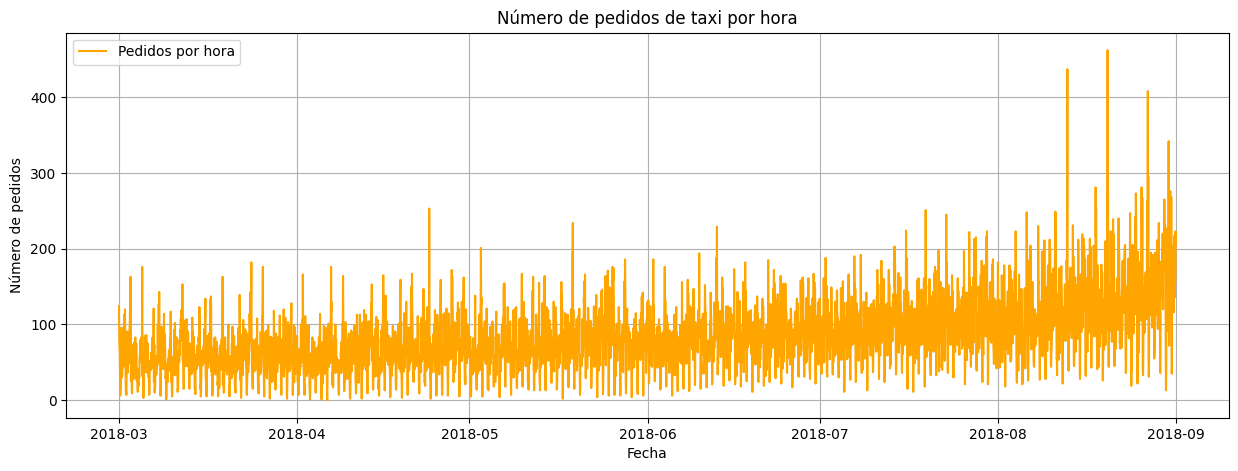

In [7]:
plt.figure(figsize=(15, 5))
plt.plot(df_resampled.index, df_resampled['num_orders'], color='orange', label='Pedidos por hora')
plt.title('Número de pedidos de taxi por hora')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.grid(True)
plt.legend()
plt.show()

En la siguiente gráfica mostramos un remuestro de pedidos por hora del día, obteniendo los siguientes resultados:

1. Desde marzo hasta finales de agosto, se observa una clara tendencia ascendente en la cantidad de pedidos por hora.

2. A lo largo de toda la serie, se presentan picos pronunciados que alcanzan más de 400 pedidos por hora en ciertos momentos.

3. En los últimos dos meses (julio y agosto), se intensifican los picos de demanda.

4. Aunque hay una tendencia clara, la línea tiene muchas oscilaciones rápidas (ruido), lo que justifica el uso posterior de una media móvil o de modelos que incorporen estacionalidad y retardos.

## Análisis

In [8]:
# Estadísticas generales
print("Estadísticas descriptivas:")
display(df_resampled['num_orders'].describe())

# Revisamos si existen valores nulos
print("\n Valores nulos")
print(df_resampled.isnull().sum())

Estadísticas descriptivas:


count    4416.000000
mean       84.422781
std        45.023853
min         0.000000
25%        54.000000
50%        78.000000
75%       107.000000
max       462.000000
Name: num_orders, dtype: float64


 Valores nulos
num_orders    0
dtype: int64


Analizando la estadística descriptiva obtenemos los siguientes resultados:

1. La media y mediana están relativamente cerca (84 vs 78), lo que indica una distribución no muy sesgada, pero el valor máximo (462) es muy alto hay posibles valores atípicos (picos extremos de demanda).

2. La desviación estándar es elevada (45), lo que muestra una alta variabilidad en la demanda por hora.

3. El mínimo es 0, lo cual puede reflejar horas sin actividad, probablemente durante la madrugada.

También, al realizar un análisis sobre valores nulos que afecten el rendimiento en el entrenamiento de nuestros modelos encontramos que no hay valores nulos en ninguna de las columnas.

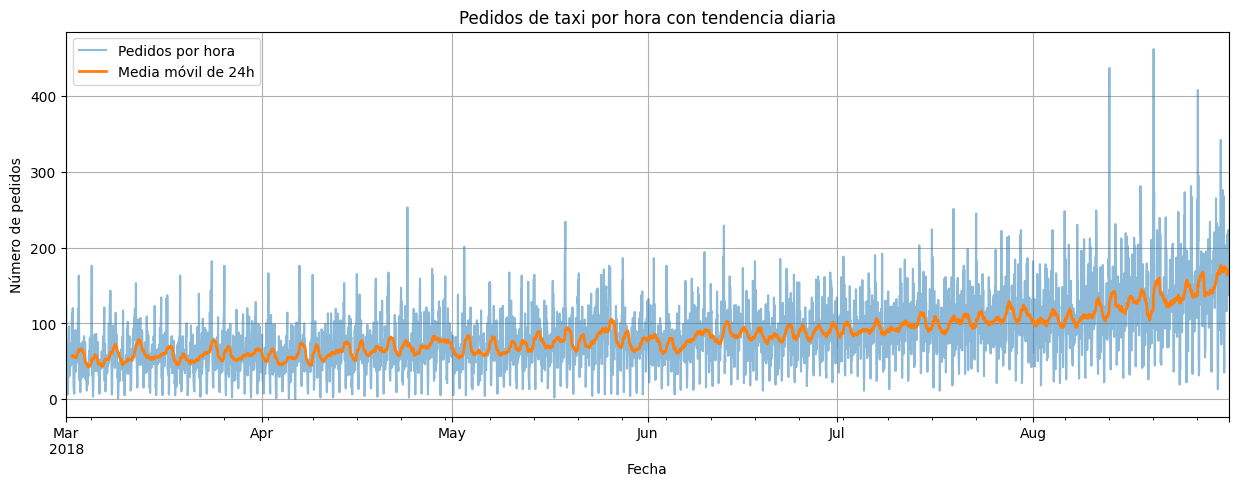

In [9]:
# Media móvil de 24 horas (tendencia diaria)

plt.figure(figsize=(15, 5))
df_resampled['num_orders'].plot(label='Pedidos por hora', alpha=0.5)
df_resampled['num_orders'].rolling(24).mean().plot(label='Media móvil de 24h', linewidth=2)
plt.title('Pedidos de taxi por hora con tendencia diaria')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.legend()
plt.grid(True)
plt.show()

1. La demanda de taxis muestra una tendencia ascendente constante entre marzo y agosto de 2018.

2. A partir de junio, la media móvil comienza a aumentar más rápidamente, lo que indica un crecimiento sostenido en la demanda horaria.

3. Se observan oscilaciones regulares de corto plazo, que sugieren un patrón diario o semanal; esto implica que la demanda no es aleatoria, sino que sigue ciclos repetitivos, posiblemente asociados a horarios laborales, vuelos, o hábitos urbanos.

**La serie azul (pedidos por hora) presenta alta dispersión y picos frecuentes, algunos muy altos (≥ 400). Aunque la tendencia es predecible, hay momentos con picos de demanda muy inusuales, probablemente en eventos específicos o ciertas franjas horarias (por ejemplo, vuelos nocturnos o eventos masivos).**

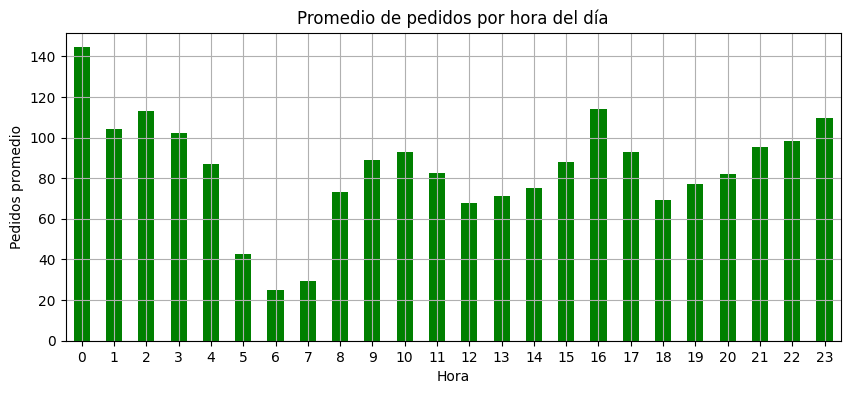

In [10]:
# Gráfica por hora del día para detectar patrones horarios

df_resampled['Hora'] = df_resampled.index.hour
hourly_avg = df_resampled.groupby('Hora')['num_orders'].mean()

plt.figure(figsize=(10, 4))
hourly_avg.plot(kind='bar')
plt.title('Promedio de pedidos por hora del día')
plt.xlabel('Hora del día')
plt.ylabel('Pedidos promedio')
hourly_avg.plot(kind='bar', color='green')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

1. La hora co mayor demanda es a la media noche (00:00 horas) tiene el pico más alto de pedidos promedio (145 aprox). Los siguientes valores elevados se representan en los horarios de 16:00 a 17:00 h (115 aprox) 23:00 h (110 aprox)

2. Esto sugiere que hay alta actividad en horarios nocturnos y tarde-noche, lo cual podría estar relacionado con las llegadas o salidas de vuelos tarde/noche, cambios de turno en trabajos, eventos o salidas nocturnas, etc.

3. La demanda disminuye notablemente entre las 4:00 y 7:00 h, alcanzando su punto más bajo a las 6:00 h (25 pedidos aprox)

**La demanda de taxis muestra variaciones significativas según la hora del día, con picos pronunciados en la medianoche y al final del día, y mínimos entre las 4:00 y 7:00 h.**

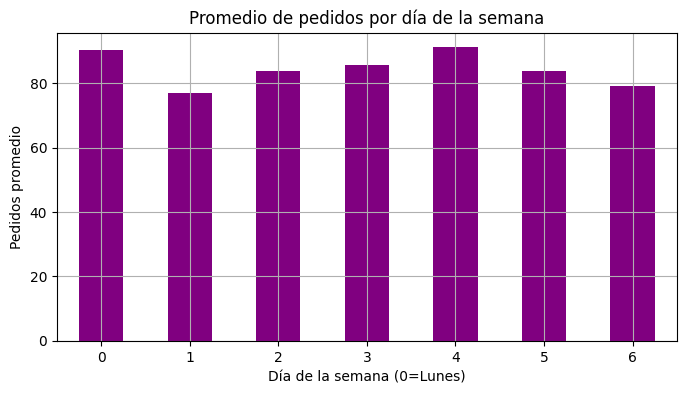

In [11]:
# Gráfica por día de la semana

df_resampled['day_of_week'] = df_resampled.index.dayofweek
dow_avg = df_resampled.groupby('day_of_week')['num_orders'].mean()

plt.figure(figsize=(8, 4))
dow_avg.plot(kind='bar', color='purple')  # ← aquí cambiamos el color
plt.title('Promedio de pedidos por día de la semana')
plt.xlabel('Día de la semana (0=Lunes)')
plt.ylabel('Pedidos promedio')
plt.xticks(rotation=0)
plt.grid(True)
plt.show()

1. Los días con mayor demanda son los lunes (0) y viernes (4) destacan con los valores más altos de pedidos promedio (91 aprox).

2. El lunes refleja probablemente el reinicio de la actividad laboral/empresarial.

3. El viernes puede estar influenciado por viajes, eventos, traslados de fin de semana.

4. Los dias con menor demanda son domingo (6) y martes (1) son los de menor promedio (78–80 aprox).

**Aunque la variación por día de la semana es menos marcada que la horaria, existen diferencias consistentes: lunes y viernes tienen mayor demanda; domingos, la menor.**

## Formación

In [12]:
# Copiamos el DataSet para no interferir con la visualización de algunos datos
data = df_resampled.copy()

# Creamos la variables de tiempo
data['hour'] = data.index.hour
data['day_of_week'] = data.index.dayofweek

# Creamos las variables de retraso (lags)
for lag in range(1, 25):  # Últimas 24 horas
    data[f'lag_{lag}'] = data['num_orders'].shift(lag)

# Eliminamos las primeras 24 filas con NaN por los lags
data = data.dropna()

# Definimos las variables predictoras (X) y objetivo (y)
X = data.drop(columns='num_orders')
y = data['num_orders']

# Dividimos las variables en: 90% entrenamiento, 10% prueba respetando el orden temporal
split_index = int(len(X) * 0.9)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print(f"Tamaño entrenamiento: {X_train.shape}")
print(f"Tamaño prueba: {X_test.shape}")


Tamaño entrenamiento: (3952, 27)
Tamaño prueba: (440, 27)


El tamaño de nuestro conjunto de entrenamiento es de: 3,952 muestras

El tamaño de nuestro conjunto de prueba es de: 440 muestras. Esto representa el 10% final del conjunto de datos.

In [13]:
# Entrenamos el modelo
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Realizamos la predicción
y_pred_lr = lr_model.predict(X_test)

# Evaluar con RMSE
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f" RMSE del modelo de regresión lineal: {rmse_lr:.2f}")

 RMSE del modelo de regresión lineal: 45.22


RMSE obtenido: 45.22

Umbral esperado: ≤ 48

**La regresión lineal ofrece un rendimiento aceptable para una primera aproximación, lo que indica que las variables actuales (hora, día y lags) tienen potencial predictivo real.**

In [14]:
# Definimos el modelo base
rf = RandomForestRegressor(random_state=42, n_jobs=-1)

# Reducimos el hiperparametro con grid para eficiencia
param_grid = {
    'n_estimators': [50, 100],
    'max_depth': [5, 10, None]
}

# Variación cruzada
grid_search = GridSearchCV(rf, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Aplicamos el mejor modelo
best_rf = grid_search.best_estimator_

# Predicción
y_pred_rf = best_rf.predict(X_test)

# Evaluación
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f" RMSE del Bosque Aleatorio: {rmse_rf:.2f}")


 RMSE del Bosque Aleatorio: 42.90


El modelo mejoró el RMSE en comparación con la regresión lineal.

Por lo tanto: 

1. Hay relaciones no lineales entre las variables que el bosque captura mejor.

2. Las características temporales (hora, día, lags) están bien diseñadas.

3. El bosque aleatorio ofrece una mejora sólida en el rendimiento.

In [15]:
# Definimos el siguiente modelo base
lgb_model = lgb.LGBMRegressor(random_state=42, n_jobs=-1)

# Hiperparametros 
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [5, 10, -1]
}

# Ajustamos con búsqueda de grilla
grid_search_lgb = GridSearchCV(lgb_model, param_grid, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search_lgb.fit(X_train, y_train)

# Obtenemos el mejor modelo
best_lgb = grid_search_lgb.best_estimator_

# Predecir sobre conjunto de prueba
y_pred_lgb = best_lgb.predict(X_test)

# Evaluamos RMSE
rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))
print(f" RMSE de LightGBM: {rmse_lgb:.2f}")

 RMSE de LightGBM: 40.64


LightGBM logró el mejor desempeño hasta ahora, con un RMSE muy por debajo del umbral de 48. Esto indica que capta eficazmente la relación no lineal entre las variables temporales y la demanda de taxis.nTambién destaca su capacidad para manejar variables con muchos valores faltantes (por lags) y sin necesidad de escalado.

**LightGBM es actualmente el mejor modelo, y sería un excelente candidato para producción si se mantiene la estabilidad.**

## Prueba

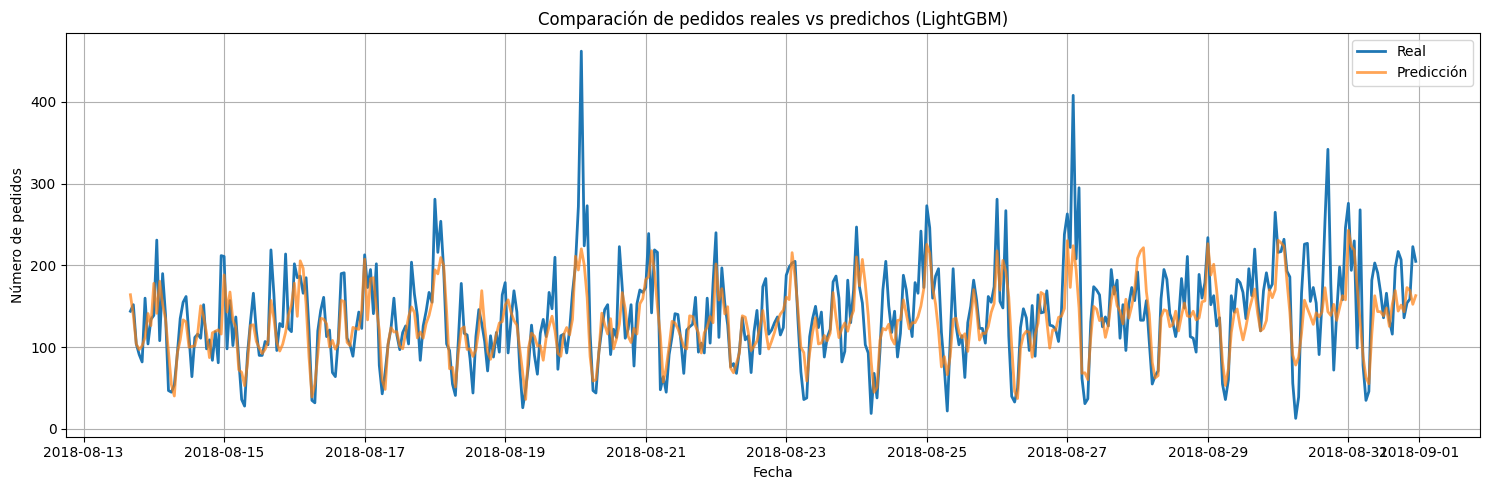

In [16]:
# Comparamos los pedidos reales contra los predichos con el mejor modelo (lightGBM)
comparison = pd.DataFrame({
    'Real': y_test.values,
    'Predicción': y_pred_lgb
}, index=y_test.index)

# Gráficamos
plt.figure(figsize=(15, 5))
plt.plot(comparison.index, comparison['Real'], label='Real', linewidth=2)
plt.plot(comparison.index, comparison['Predicción'], label='Predicción', linewidth=2, alpha=0.7)
plt.title('Comparación de pedidos reales vs predichos (LightGBM)')
plt.xlabel('Fecha')
plt.ylabel('Número de pedidos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


La línea naranja (predicción) sigue de forma bastante fiel la forma de la línea azul (real). Esto indica que el modelo está capturando correctamente la tendencia y estacionalidad horaria. No existe desfase temporal evidenteLas predicciones están alineadas en el tiempo con los datos reales, sin retraso o adelanto sistemático.

**El modelo entrenado con LightGBM predice con éxito el número de pedidos de taxis por hora en aeropuertos. Con un RMSE de 40.64 sobre el conjunto de prueba, superando la expectativa de RMSE de <48. El modelo aprovecha variables temporales (hora, día de la semana) y retardos (lag_1 a lag_24), logrando captar tanto estacionalidad como dependencia temporal.**
Como conclusión:

1. La demanda tiene una tendencia creciente y patrón horario fuerte.

2. Variables como la hora del día y pedidos anteriores son altamente predictivas.

3. LightGBM fue el modelo con mejor desempeño, con un RMSE de 40.64 (objetivo cumplido).

4. La gráfica de comparación confirma la calidad de las predicciones.

# Lista de revisión

- [x] Jupyter Notebook está abierto.
- [x] El código no tiene errores
- [x] Las celdas con el código han sido colocadas en el orden de ejecución.
- [x] Los datos han sido descargados y preparados.
- [x] Se ha realizado el paso 2: los datos han sido analizados
- [x] Se entrenó el modelo y se seleccionaron los hiperparámetros
- [x] Se han evaluado los modelos. Se expuso una conclusión
- [x] La *RECM* para el conjunto de prueba no es más de 48